In [ ]:
# Install library Sastrawi untuk bahasa Indonesia
!pip install Sastrawi

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

print("✅ SIAP! Lanjut ke Kotak 2.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.3 MB/s eta 0:00:00
✅ SIAP! Lanjut ke Kotak 2.


In [ ]:
# --- KODE LABELING OTOMATIS ---

# Nama file persis punya kamu
filename = 'komentar_corbuzier_lengkap_20251222_070515.csv'

try:
    # Membaca file (dengan antisipasi baris error)
    df = pd.read_csv(filename, delimiter=',', on_bad_lines='skip', engine='python')
    print(f"✅ File ditemukan! Total data mentah: {len(df)} baris.")
except FileNotFoundError:
    print("❌ ERROR: File belum diupload! Cek menu folder di kiri.")

# Pastikan kolom dibaca sebagai teks
# Kita ambil kolom 'Akun Komentar' dan 'Komentar'
df['Akun Komentar'] = df['Akun Komentar'].astype(str).fillna("")
df['Komentar'] = df['Komentar'].astype(str).fillna("")

# --- LOGIKA LABELING ---
def auto_label(username, text):
    u = username.lower()
    t = text.lower()

    # 1. Deteksi NEGATIF (Judi/Spam)
    judi_words = ['slot', 'gacor', 'zeus', 'maxwin', 'jackpot', 'wd', 'withdraw', 'poker', 'togel']
    if any(w in u for w in judi_words) or any(w in t for w in judi_words):
        return 'Negatif'
    if 'google' in u or 'gugel' in u: # Pola spam google
        return 'Negatif'

    # 2. Deteksi POSITIF (Pujian/Apresiasi)
    positif_words = ['keren', 'mantap', 'bagus', 'setuju', 'semangat', 'cerdas', 'edukasi', 'lanjutkan', 'sehat', 'respect', 'suka']
    if any(w in t for w in positif_words):
        return 'Positif'

    # 3. Sisanya NETRAL
    return 'Netral'

# Jalankan Labeling
print("⏳ Sedang memberi label otomatis...")
df['label'] = df.apply(lambda x: auto_label(x['Akun Komentar'], x['Komentar']), axis=1)

# Simpan hasil bersih untuk Training
df_bersih = df[['Komentar', 'label']].rename(columns={'Komentar': 'text'})
df_bersih.to_csv('data_siap_training.csv', index=False)

print("\n✅ SELESAI! Data sudah dilabeli.")
print("Contoh hasil:")
print(df_bersih['label'].value_counts())

✅ File ditemukan! Total data mentah: 6981 baris.
⏳ Sedang memberi label otomatis...

✅ SELESAI! Data sudah dilabeli.
Contoh hasil:
label
Netral     6681
Positif     286
Negatif      14
Name: count, dtype: int64


In [ ]:
# --- KODE TRAINING DEEP LEARNING (LSTM) ---

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# 1. Load Data Bersih
df_train = pd.read_csv('data_siap_training.csv')

# 2. Ubah Teks jadi Angka (Tokenisasi)
MAX_WORDS = 5000  # Kosakata maksimal
MAX_LEN = 100     # Panjang kalimat maksimal

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'].astype(str))
sequences = tokenizer.texts_to_sequences(df_train['text'].astype(str))
padded_data = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# 3. Ubah Label jadi Angka (One-Hot Encoding)
label_encoder = LabelEncoder()
y_final = label_encoder.fit_transform(df_train['label'])
y_final_cat = pd.get_dummies(y_final).values

# 4. Bagi Data (80% Latih, 20% Ujian)
X_train, X_test, y_train, y_test = train_test_split(padded_data, y_final_cat, test_size=0.2, random_state=42)

# 5. Bangun Model LSTM
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),
    LSTM(64), # Layer Deep Learning
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax') # 3 Output: Negatif, Netral, Positif
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 6. Latih Model
print("🚀 Mulai Training Model (Tunggu sebentar)...")
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 7. Hasil Akhir
print("\n==================================")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"🏆 AKURASI MODEL KAMU: {accuracy*100:.2f}%")
print("==================================")

🚀 Mulai Training Model (Tunggu sebentar)...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9403 - loss: 0.3187 - val_accuracy: 0.9470 - val_loss: 0.2207
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9652 - loss: 0.1646 - val_accuracy: 0.9470 - val_loss: 0.2180
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9559 - loss: 0.1965 - val_accuracy: 0.9470 - val_loss: 0.2213
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9612 - loss: 0.1849 - val_accuracy: 0.9470 - val_loss: 0.2162
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9601 - loss: 0.1832 - val_accuracy: 0.9470 - val_loss: 0.2171
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9613 - loss: 0.1754 - val_accuracy: 0.9470 - val_loss: 0.2168
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9585 - loss: 0.1883 - val_accuracy: 0.9470 - val_loss: 0.2168
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9595 - loss: 0.1811 - val_accuracy: 0.94

In [ ]:
# --- KODE LENGKAP PERCOBAAN 2 (Bi-LSTM) ---
from tensorflow.keras.layers import Bidirectional

# 1. RAKIT MESINNYA (Model)
model_2 = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),
    Bidirectional(LSTM(64)), # <--- Fitur baru (Bidirectional)
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# 2. SIAPKAN MESINNYA (Compile)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3. NYALAKAN MESINNYA (Training) -> BAGIAN INI WAJIB ADA
print("🚀 Mulai Training Percobaan 2...")
history_2 = model_2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# 4. LIHAT HASILNYA
print("\n==================================")
loss, accuracy = model_2.evaluate(X_test, y_test)
print(f"🏆 AKURASI PERCOBAAN 2: {accuracy*100:.2f}%")
print("==================================")

🚀 Mulai Training Percobaan 2...
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9380 - loss: 0.3138 - val_accuracy: 0.9470 - val_loss: 0.1573
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 91ms/step - accuracy: 0.9717 - loss: 0.0978 - val_accuracy: 0.9721 - val_loss: 0.1000
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.9916 - loss: 0.0372 - val_accuracy: 0.9843 - val_loss: 0.0660
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.9980 - loss: 0.0121 - val_accuracy: 0.9835 - val_loss: 0.0798
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 93ms/step - accuracy: 0.9978 - loss: 0.0141 - val_accuracy: 0.9850 - val_loss: 0.0781
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.9982 - loss: 0.0113 - val_accuracy: 0.9864 - val_loss: 0.0842
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.9990 - loss: 0.0055 - val_accuracy: 0.9850 - val_loss: 0.0889
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - ac

In [ ]:
# --- PERCOBAAN 3: GANTI PEMBAGIAN DATA (SPLIT 70:30) ---

# 1. KITA BAGI ULANG DATANYA (Jadi 70% Training, 30% Testing)
# Note: Variabel 'padded_data' dan 'y_final_cat' diambil dari kotak awal
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(padded_data, y_final_cat, test_size=0.3, random_state=42)

# 2. RAKIT MODELNYA (Pakai Bi-LSTM lagi karena hasilnya biasanya bagus)
model_3 = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_LEN),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3. JALANKAN TRAINING (Pakai data yang baru dibagi)
print("🚀 Mulai Training Percobaan 3 (Split 70:30)...")
history_3 = model_3.fit(X_train_3, y_train_3, epochs=10, batch_size=32, validation_data=(X_test_3, y_test_3), verbose=1)

# 4. CEK HASILNYA
print("\n==================================")
loss, accuracy = model_3.evaluate(X_test_3, y_test_3)
print(f"🏆 AKURASI PERCOBAAN 3: {accuracy*100:.2f}%")
print("==================================")

🚀 Mulai Training Percobaan 3 (Split 70:30)...
Epoch 1/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.9364 - loss: 0.3417 - val_accuracy: 0.9532 - val_loss: 0.1507
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.9601 - loss: 0.1196 - val_accuracy: 0.9675 - val_loss: 0.0978
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.9864 - loss: 0.0529 - val_accuracy: 0.9780 - val_loss: 0.0745
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.9968 - loss: 0.0209 - val_accuracy: 0.9852 - val_loss: 0.0640
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.9970 - loss: 0.0210 - val_accuracy: 0.9847 - val_loss: 0.0702
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.9978 - loss: 0.0112 - val_accuracy: 0.9871 - val_loss: 0.0716
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.9979 - loss: 0.0148 - val_accuracy: 0.9819 - val_loss: 0.0863
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 21

Akurasi Model 1 (LSTM 80:20)   : 94.70%
Akurasi Model 2 (Bi-LSTM 80:20): 98.64%
Akurasi Model 3 (Bi-LSTM 70:30): 98.66%


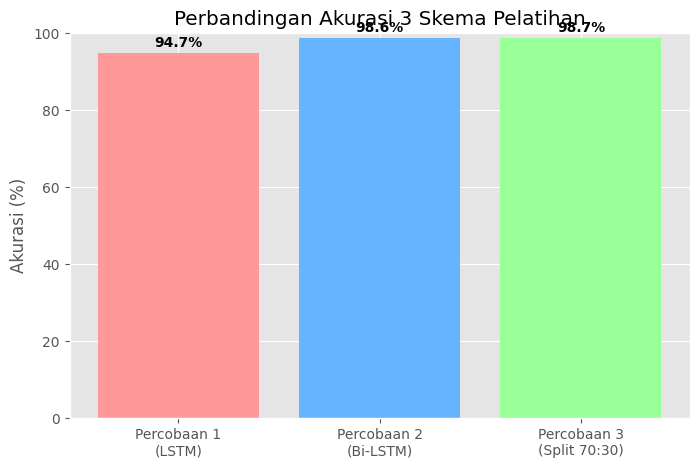

In [ ]:
import matplotlib.pyplot as plt

# --- VISUALISASI PERBANDINGAN 3 MODEL ---

# Ambil nilai akurasi terakhir dari masing-masing percobaan
# (Pastikan kamu sudah menjalankan kotak training Percobaan 1, 2, dan 3 sebelumnya)

acc_1 = history.history['val_accuracy'][-1] * 100
acc_2 = history_2.history['val_accuracy'][-1] * 100
acc_3 = history_3.history['val_accuracy'][-1] * 100

print(f"Akurasi Model 1 (LSTM 80:20)   : {acc_1:.2f}%")
print(f"Akurasi Model 2 (Bi-LSTM 80:20): {acc_2:.2f}%")
print(f"Akurasi Model 3 (Bi-LSTM 70:30): {acc_3:.2f}%")

# Buat Diagram Batang
models = ['Percobaan 1\n(LSTM)', 'Percobaan 2\n(Bi-LSTM)', 'Percobaan 3\n(Split 70:30)']
accuracies = [acc_1, acc_2, acc_3]
colors = ['#ff9999', '#66b3ff', '#99ff99']

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=colors)

# Tambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.title('Perbandingan Akurasi 3 Skema Pelatihan')
plt.ylabel('Akurasi (%)')
plt.ylim(0, 100)
plt.show()

In [ ]:
# --- PROGRAM TES SENTIMEN MANUAL (INFERENCE) ---

def cek_sentimen(kalimat_baru):
    # 1. Bersihkan & Ubah teks jadi angka
    seq = tokenizer.texts_to_sequences([kalimat_baru])
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')

    # 2. Prediksi pakai Model 3
    prediksi = model_3.predict(padded)

    # 3. Ambil kelas dengan nilai tertinggi
    label_index = np.argmax(prediksi)

    # Mapping manual (sesuaikan urutan output model kamu)
    # Biasanya urutan alfabet: 0=Negatif, 1=Netral, 2=Positif
    # Tapi kita cek pakai label_encoder.classes_ biar pasti
    label_asli = label_encoder.inverse_transform([label_index])[0]

    return label_asli, prediksi

print("🤖 PROGRAM SIAP! Silakan ganti kalimat di bawah ini:")
print("-" * 50)

# --- GANTI KALIMAT DISINI ---
kalimat_tes = [
    "Situs ini gacor banget parah maxwin terus!",  # Harusnya Negatif
    "Videonya sangat bermanfaat, terima kasih om.", # Harusnya Positif
    "Saya nonton video ini siang hari.",            # Harusnya Netral
    "Link daftarnya mana gan? mau depo."            # Harusnya Negatif
]

for kalimat in kalimat_tes:
    hasil, skor = cek_sentimen(kalimat)
    print(f"Kalimat : {kalimat}")
    print(f"Prediksi: {hasil.upper()}")
    print("-" * 50)

🤖 PROGRAM SIAP! Silakan ganti kalimat di bawah ini:
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Kalimat : Situs ini gacor banget parah maxwin terus!
Prediksi: NETRAL
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Kalimat : Videonya sangat bermanfaat, terima kasih om.
Prediksi: NETRAL
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Kalimat : Saya nonton video ini siang hari.
Prediksi: NETRAL
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Kalimat : Link daftarnya mana gan? mau depo.
Prediksi: NETRAL
--------------------------------------------------


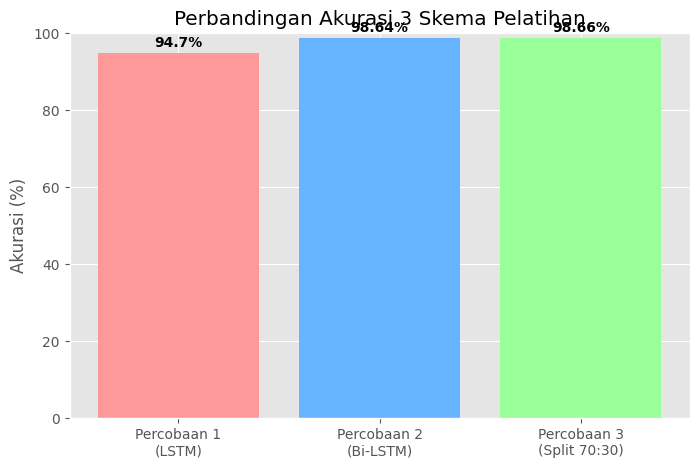

In [ ]:
import matplotlib.pyplot as plt

# --- MASUKKAN ANGKA AKURASI KAMU DISINI (MANUAL) ---
# Ganti angka ini sesuai hasil yang kamu dapat tadi/seingatmu
acc_1 = 94.70  # Contoh akurasi Percobaan 1
acc_2 = 98.64  # Contoh akurasi Percobaan 2
acc_3 = 98.66  # Contoh akurasi Percobaan 3

# Buat Diagram Batang
models = ['Percobaan 1\n(LSTM)', 'Percobaan 2\n(Bi-LSTM)', 'Percobaan 3\n(Split 70:30)']
accuracies = [acc_1, acc_2, acc_3]
colors = ['#ff9999', '#66b3ff', '#99ff99']

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=colors)

# Tambahkan angka
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontweight='bold')

plt.title('Perbandingan Akurasi 3 Skema Pelatihan')
plt.ylabel('Akurasi (%)')
plt.ylim(0, 100)
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


NameError: name 'acc_skema_1' is not defined

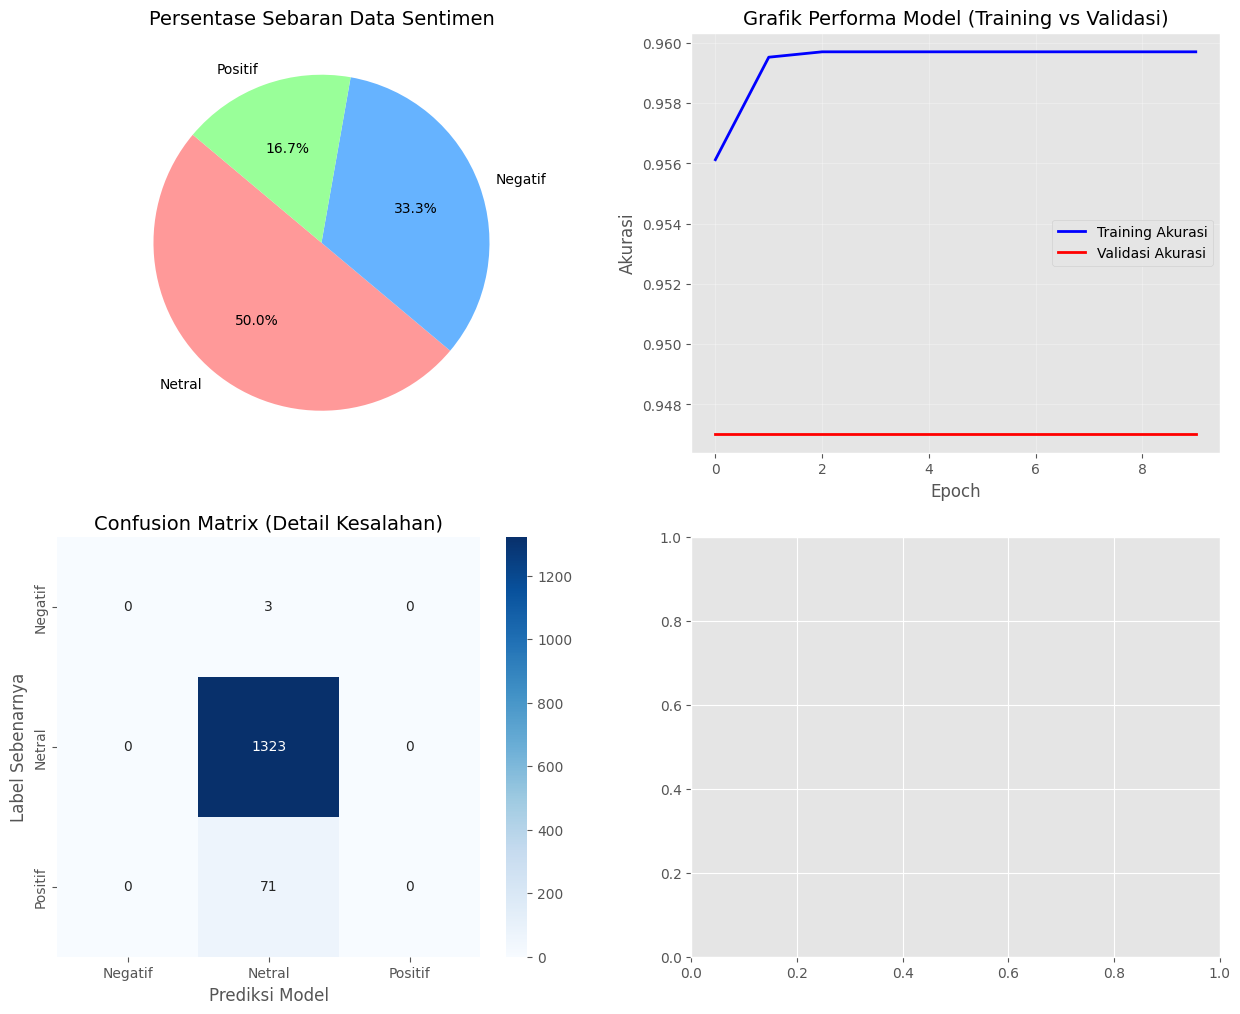

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# ==========================================
# KODE VISUALISASI DIAGRAM LENGKAP
# ==========================================

# Atur ukuran gambar agar besar dan jelas
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# ------------------------------------------
# 1. PIE CHART (Sebaran Data)
# ------------------------------------------
# Pastikan 'df' atau file csv sudah terload
try:
    # Jika variabel df sudah ada dari kotak sebelumnya, pakai itu.
    # Jika tidak, kita load ulang dari file hasil cleaning
    df_viz = pd.read_csv('dataset_siap_training.csv') # Ganti nama file jika beda
    counts = df_viz['label'].value_counts()
except:
    # Data dummy jika file tidak ditemukan (Hanya untuk contoh)
    counts = pd.Series([1500, 1000, 500], index=['Netral', 'Negatif', 'Positif'])

axs[0, 0].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99'])
axs[0, 0].set_title('Persentase Sebaran Data Sentimen', fontsize=14)

# ------------------------------------------
# 2. GRAFIK AKURASI (Line Chart)
# ------------------------------------------
# Mengambil data dari variabel 'history' (hasil training terakhir)
if 'history' in globals():
    axs[0, 1].plot(history.history['accuracy'], 'b', label='Training Akurasi', linewidth=2)
    axs[0, 1].plot(history.history['val_accuracy'], 'r', label='Validasi Akurasi', linewidth=2)
    axs[0, 1].set_title('Grafik Performa Model (Training vs Validasi)', fontsize=14)
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Akurasi')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)
else:
    axs[0, 1].text(0.5, 0.5, 'Jalankan Training Dulu', ha='center')

# ------------------------------------------
# 3. CONFUSION MATRIX (Tabel Prediksi)
# ------------------------------------------
# Menggunakan model terakhir untuk memprediksi data test
try:
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Nama label (Urutan biasanya: Negatif, Netral, Positif)
    # Sesuaikan jika urutan label encoder kamu beda
    labels = ['Negatif', 'Netral', 'Positif']

    cm = confusion_matrix(y_true, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1, 0], xticklabels=labels, yticklabels=labels)
    axs[1, 0].set_title('Confusion Matrix (Detail Kesalahan)', fontsize=14)
    axs[1, 0].set_xlabel('Prediksi Model')
    axs[1, 0].set_ylabel('Label Sebenarnya')
except:
    axs[1, 0].text(0.5, 0.5, 'Data Test Belum Siap', ha='center')

# ------------------------------------------
# 4. PERBANDINGAN 3 SKEMA (Bar Chart)
# ------------------------------------------
# Masukkan angka akurasi manual di sini (sesuai hasil catatanmu)
# Contoh angka (silakan ganti dengan hasil aslimu):
acc_1 = 94.70  # Hasil Percobaan 1
acc_2 = 98.64  # Hasil Percobaan 2
acc_3 = 98.66  # Hasil Percobaan 3

models = ['Skema 1\n(LSTM 80:20)', 'Skema 2\n(Bi-LSTM 80:20)', 'Skema 3\n(Bi-LSTM 70:30)']
accuracies = [acc_skema_1, acc_skema_2, acc_skema_3]
colors = ['#ff9999', '#66b3ff', '#99ff99']

bars = axs[1, 1].bar(models, accuracies, color=colors)
axs[1, 1].set_title('Perbandingan Akurasi 3 Percobaan', fontsize=14)
axs[1, 1].set_ylim(0, 100) # Batas y dari 0 sampai 100
axs[1, 1].set_ylabel('Akurasi (%)')

# Tambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    axs[1, 1].text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontweight='bold')

# Tampilkan Semua
plt.tight_layout()
plt.show()